In [3]:
import yfinance as yf
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [20]:

# Fetch historical data for Bitcoin (BTC-USD)
crypto = 'BTC-USD'
data = yf.download(crypto, start="2020-01-01", interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [21]:

# Calculate technical indicators
data['SMA'] = ta.trend.sma_indicator(data['Close'], window=20)
data['EMA'] = ta.trend.ema_indicator(data['Close'], window=20)
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd_diff(data['Close'])
data['Bollinger_Middle'] = ta.volatility.bollinger_mavg(data['Close'])
data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'])

# Drop rows with NaN values
data.dropna(inplace=True)


In [22]:

# Resample data to weekly frequency
weekly_data = data.resample('W').last()

# Create the target variable (1 for buy, 0 for not buy)
weekly_data['Target'] = (weekly_data['Close'].shift(-1) > weekly_data['Close']).astype(int)

# Drop the last row (where the target is NaN)
weekly_data.dropna(inplace=True)


In [36]:
weekly_data

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI,MACD,Bollinger_Middle,Bollinger_High,Bollinger_Low,Target
Date,,,,,,,,,,,,,,
2020-02-09,9863.894531,10129.435547,9850.392578,10116.673828,10116.673828,35807884663,9201.032324,9287.659907,76.204072,45.342388,9201.032324,10213.814123,8188.250525,0
2020-02-16,9889.179688,10053.968750,9722.386719,9934.433594,9934.433594,43374780305,9730.434277,9695.492376,59.891859,-26.132760,9730.434277,10462.883296,8997.985259,0
2020-02-23,9663.318359,9937.404297,9657.791016,9924.515625,9924.515625,41185185761,9869.566064,9729.214952,56.525245,-86.469229,9869.566064,10431.335523,9307.796606,0
2020-03-01,8599.758789,8726.796875,8471.212891,8562.454102,8562.454102,35349164300,9583.204980,9287.231046,34.360692,-186.802563,9583.204980,10738.297099,8428.112862,0
2020-03-08,8908.206055,8914.343750,8105.252930,8108.116211,8108.116211,39973102121,9136.069629,9030.278615,32.845039,-70.143820,9136.069629,10184.401576,8087.737682,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541,68369.058984,67832.213123,45.423953,-522.730974,68369.058984,71269.739219,65468.378750,0
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802,67216.835547,66168.853843,33.384915,-528.170330,67216.835547,71977.787167,62455.883927,0
2024-06-30,60888.445312,62892.828125,60632.949219,62678.292969,62678.292969,17333226409,64125.213477,63701.735766,43.616657,-253.055575,64125.213477,69056.715764,59193.711189,0


In [23]:

# Define the feature columns
features = ['SMA', 'EMA', 'RSI', 'MACD', 'Bollinger_Middle', 'Bollinger_High', 'Bollinger_Low']

# Create the feature matrix (X) and target vector (y)
X = weekly_data[features]
y = weekly_data['Target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [24]:

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy: 0.5319148936170213
              precision    recall  f1-score   support

           0       0.51      0.87      0.65        23
           1       0.62      0.21      0.31        24

    accuracy                           0.53        47
   macro avg       0.57      0.54      0.48        47
weighted avg       0.57      0.53      0.48        47



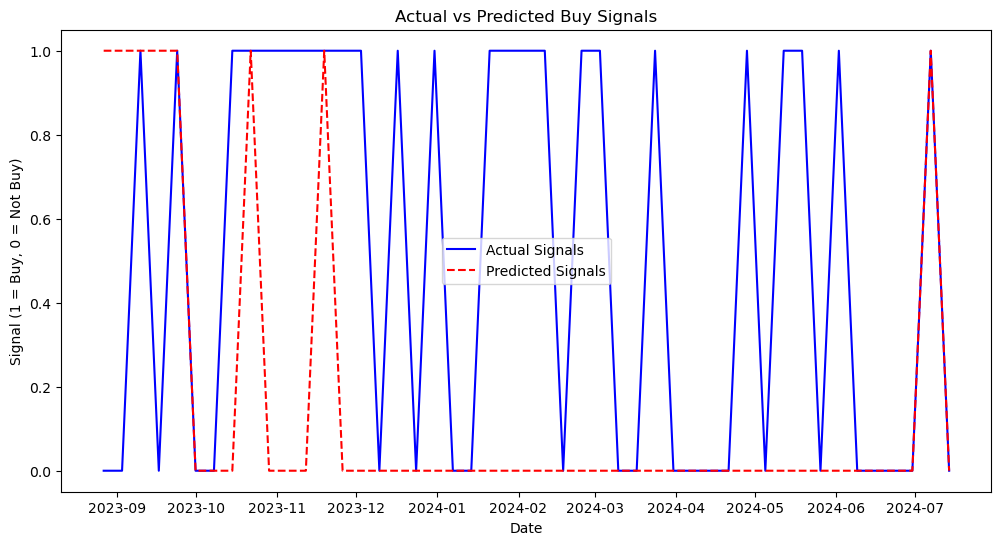

In [25]:

# Plot actual vs predicted signals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Signals', color='b')
plt.plot(y_test.index, y_pred, label='Predicted Signals', color='r', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Signal (1 = Buy, 0 = Not Buy)')
plt.title('Actual vs Predicted Buy Signals')
plt.show()


<Axes: xlabel='Date'>

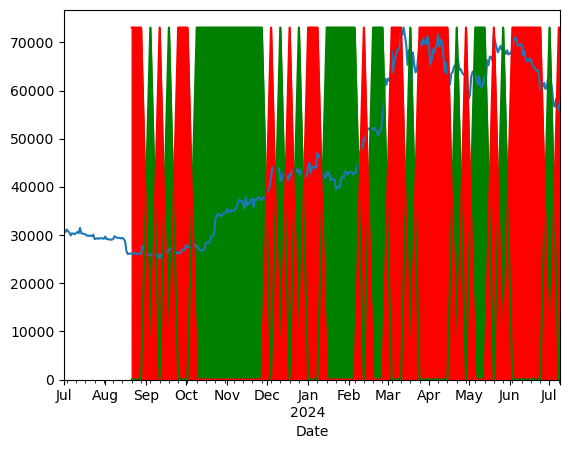

In [38]:

plot_pred = y_test.copy()
price_data = data.loc['2023-7-1':,'Close']
price_data.plot()
plot_pred.replace(1,price_data.max()).plot(kind='area', color = 'g')
plot_pred.replace(0,price_data.max()).plot(kind='area', color = 'r')



In [40]:
y_pred[-1]

0